# Tutorial II: Using Runner Basics

First we have to import the required modules. Let's also disable some annoying warnings.

In [1]:
import sys
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from hdbscan import HDBSCAN
from numba.errors import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from dpemu.nodes import Array
from dpemu import runner
from dpemu.dataset_utils import load_digits_, load_mnist, load_fashion
from dpemu.ml_utils import reduce_dimensions
from dpemu.plotting_utils import visualize_best_model_params, visualize_scores, visualize_classes, print_results_by_model, visualize_interactive_plot
from dpemu.problemgenerator.filters import GaussianNoise, Clip

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

/home/thalvari/PycharmProjects/dpEmu/venv/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/thalvari/PycharmProjects/dpEmu/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(42)

    def run(self, _, data, params):
        reduced_data = reduce_dimensions(data, self.random_state)
        return None, reduced_data, {"reduced_data": reduced_data}

In [3]:
class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, data, params):
        pass

    def run(self, _, data, params):
        labels = params["labels"]
        fitted_model = self.get_fitted_model(data, params)
        return {
            "AMI": round(adjusted_mutual_info_score(labels, fitted_model.labels_, average_method="arithmetic"), 3),
            "ARI": round(adjusted_rand_score(labels, fitted_model.labels_), 3),
        }


class KMeansModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return KMeans(n_clusters=n_classes, random_state=self.random_state).fit(data)


class AgglomerativeModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return AgglomerativeClustering(n_clusters=n_classes).fit(data)


class HDBSCANModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        return HDBSCAN(
            min_samples=params["min_samples"],
            min_cluster_size=params["min_cluster_size"]
        ).fit(data)

In [4]:
def get_data(argv):
    if argv[1] == "digits":
        data, labels, label_names, dataset_name = load_digits_(int(argv[2]))
    elif argv[1] == "mnist":
        data, labels, label_names, dataset_name = load_mnist(int(argv[2]))
    else:
        data, labels, label_names, dataset_name = load_fashion(int(argv[2]))
    return data, labels, label_names, dataset_name

In [5]:
def get_err_root_node():
    err_root_node = Array()
    err_root_node.addfilter(GaussianNoise("mean", "std"))
    err_root_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [6]:
def get_err_params_list(data):
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.linspace(0, max_val, num=8)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [7]:
def get_model_params_dict_list(data, labels):
    n_data = data.shape[0]
    divs = [12, 25, 50]
    min_cluster_size_steps = [round(n_data / div) for div in divs]
    min_samples_steps = [1, 10]
    return [
        {"model": KMeansModel, "params_list": [{"labels": labels}]},
        {"model": AgglomerativeModel, "params_list": [{"labels": labels}]},
        {"model": HDBSCANModel, "params_list": [{
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "labels": labels
        } for min_cluster_size in min_cluster_size_steps for min_samples in min_samples_steps]},
    ]

In [8]:
def visualize(df, label_names, dataset_name, data):
    visualize_scores(df, ["AMI", "ARI"], [True, True], "std",
                     f"{dataset_name} clustering scores with added gaussian noise")
    visualize_best_model_params(df, "HDBSCAN #1", ["min_cluster_size", "min_samples"], ["AMI", "ARI"], [True, True],
                                "std", f"Best parameters for {dataset_name} clustering")
    visualize_classes(df, label_names, "std", "reduced_data", "labels", "tab10",
                      f"{dataset_name} (n={data.shape[0]}) classes with added gaussian noise")
    plt.show()

In [9]:
def main(argv):
    if len(argv) != 3 or argv[1] not in ["digits", "mnist", "fashion"]:
        exit(0)
    data, labels, label_names, dataset_name = get_data(argv)

    df = runner.run(
        train_data=None,
        test_data=data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(data),
        model_params_dict_list=get_model_params_dict_list(data, labels),
    )

    print_results_by_model(df, ["labels", "reduced_data"])
    visualize(df, label_names, dataset_name, data)

100%|██████████| 8/8 [00:56<00:00,  8.85s/it]


Agglomerative #1
     AMI    ARI  max_val  mean  min_val        std  time_used_err  time_used_mod  time_used_pre
0  0.901  0.834     16.0     0      0.0   0.000000       0.056448       0.149048      30.488024
1  0.854  0.790     16.0     0      0.0   2.285714       0.048435       0.116836      30.355536
2  0.753  0.652     16.0     0      0.0   4.571429       0.055003       0.247463      31.214837
3  0.488  0.388     16.0     0      0.0   6.857143       0.031239       0.191701      31.867502
4  0.302  0.218     16.0     0      0.0   9.142857       0.009432       0.110400      22.517898
5  0.185  0.119     16.0     0      0.0  11.428571       0.012721       0.251477      22.766249
6  0.105  0.061     16.0     0      0.0  13.714286       0.009639       0.252416      21.423965
7  0.067  0.038     16.0     0      0.0  16.000000       0.021933       0.146588      22.623704
HDBSCAN #1
      AMI    ARI  max_val  mean  min_cluster_size  min_samples  min_val        std  time_used_err  time_used

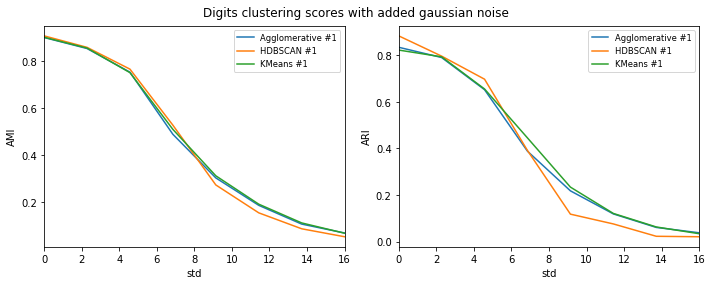

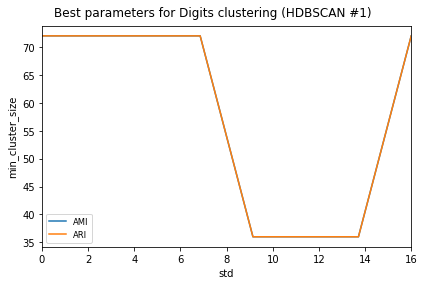

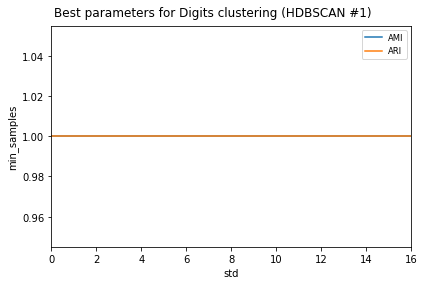

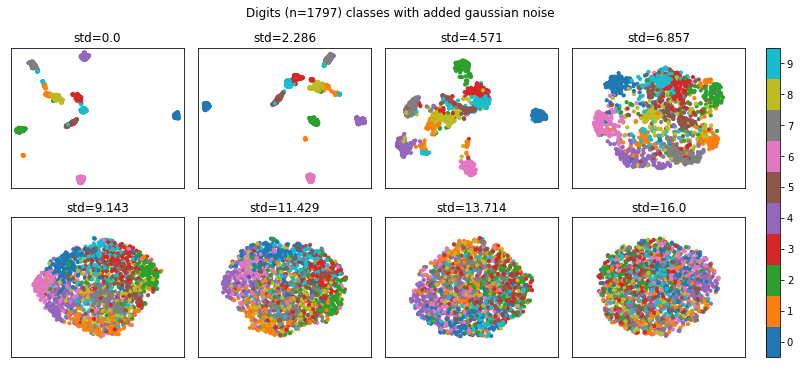

In [10]:
main(["", "digits", "1797"])